In [1]:
%matplotlib inline
import numpy as np

In [2]:
try:
    import urllib2
except:
    import urllib.request as urllib2
import json

base_api_url = 'http://neurotree.org/'
pmid = 11483306
query_url = "http://neurotree.org/beta/include/check_pmid.php?term=11483306"
response = urllib2.urlopen(query_url)

In [3]:
# import neurotree api python functions
from neurotree_api import get_investigator_path_len, get_neurotree_node_id_from_pmid, get_neurotree_node_info

# test the api functions
get_neurotree_node_info(4800)
node_id = get_neurotree_node_id_from_pmid(11483306)
#print node_id
get_investigator_path_len(77014, 4800)
get_investigator_path_len(2218, 196)

{'path2': [2715, 77014], 'stepcount': 2, 'path1': [2715, 4800], 'backonly': '1', 'pid2': 4800, 'name1': 'Shreejoy J Tripathy', 'pathcount': 2, 'name2': 'Richard C Gerkin', 'pid1': 77014, 'stepstaken': 1}
{'path2': None, 'stepcount': None, 'path1': None, 'backonly': '1', 'pid2': 196, 'name1': 'Daniel L Alkon', 'pathcount': None, 'name2': 'Claude  Bernard', 'pid1': 2218, 'stepstaken': 8}


(None, None)

In [4]:
# load the saved objects from the pairwise CA1 author path search
import pickle

# Getting back the objects:
with open('objs.pickle','rb') as f:
    path_len_mat, unique_neurotree_id_list, common_ancestor_list = pickle.load(f,encoding='latin1')

In [5]:
# convert the pariwise path len matrix to a symmetric matrix
sym_path_len_mat = path_len_mat
sym_path_len_mat[np.tril_indices(45)] = 0
sym_path_len_mat = sym_path_len_mat + sym_path_len_mat.T

In [6]:
# Load the NeuroTree distance file.  
with open('dist_mtx.txt','rb') as f:
    dist_data = json.loads(f.read().decode('latin1'))

In [9]:
# Parse the NeuroTree distance file into a matrix.  
ancestors = list(set([x['p0'] for x in dist_data])) # Extract ancestor list
regulars = list(set([x['p1'] for x in dist_data]).union(set([x['p2'] for x in dist_data]))) # Extract regular list.  
n_regulars = len(regulars) # Number of regulars.
dist_matrix = -1.0 * np.ones((n_regulars,n_regulars)) # Matrix of distances, filled with -1 (no path).  
for entry in dist_data: # Iterate over entries in the distance data.  
    p0,p1,p2,d = [entry[i] for i in ['p0','p1','p2','d']]
    d = np.inf if d=='-1' else int(d)
    x1 = regulars.index(p1) # Matrix index of individual with id p1.  
    x2 = regulars.index(p2) # Matrix index of individual with id p2.  
    dist_matrix[x1,x2] = d # Set forward distance to d.  
    dist_matrix[x2,x1] = d # Set reverse distance to d (for symmetry).  
for i in range(n_regulars): # For each individual.  
    dist_matrix[i,i] = 0 # Set the diagonal entry (self distance) to 0.  

In [10]:
# Overwrite old path length matrix and associated data with the new one.  
sym_path_len_mat, unique_neurotree_id_list, common_ancestor_list = dist_matrix, regulars, ancestors

In [11]:
# Load the neuroelectro data dump.  
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer,Imputer
import pandas as pd
df = pd.read_csv('http://dev.neuroelectro.org/static/src/article_ephys_metadata_curated.csv',delimiter='\t')

In [12]:
# sort the pairwise math length matrix by similarity
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import leaders, fclusterdata, linkage, dendrogram, leaves_list

d = squareform(sym_path_len_mat, checks = False)
Z = linkage(d)
sorted_rows = leaves_list(Z)

sorted_node_id_list = [unique_neurotree_id_list[i] for i in sorted_rows.tolist()]
try:
    none_index = sorted_node_id_list.index(None)
except ValueError:
    has_none_index = False
else:
    has_none_index = True
    del sorted_node_id_list[none_index]

sorted_author_names = [get_neurotree_node_info(int(node_id)) for node_id in sorted_node_id_list]
sorted_author_last_names = []
for n in sorted_author_names:
    if n and 'lastname' in n:
        sorted_author_last_names.append('%s, %s' % (n['lastname'], n['pid']))
    else:
        sorted_author_last_names.append('UNKN')

# sym_path_len_mat_sorted is the sorted path length distance matrix
elems = sorted_rows.tolist()
if has_none_index:
    del elems[none_index]

new_order = elems
sym_path_len_mat_sorted = sym_path_len_mat[:, new_order][new_order]

In [13]:
# define a data frame for the symmetric path length distance matrix
path_df = pd.DataFrame(data = sym_path_len_mat_sorted, index = sorted_node_id_list, columns = sorted_node_id_list)

sorted_author_last_names_df = pd.DataFrame(data = sorted_author_last_names, index = sorted_node_id_list, columns = ['names'])

In [14]:
# map neuroelectro pubmed ids to neurotree node ids
neurotree_id_list = []
cell_type_name = 'Hippocampus CA1 pyramidal cell'
ca1_df = df[df['NeuronName'].isin([cell_type_name])]
ca1_df.head()

cell_match = df['NeuronName'].isin([cell_type_name])
pmid_list = list(set(df['Pmid'][cell_match]))
df.loc[:,'NeuroTreeID'] = np.zeros(len(df['Pmid']))
pmid_to_node_dict = {}

for index, row in ca1_df.iterrows():
    pmid = row['Pmid']
    node_id = get_neurotree_node_id_from_pmid(pmid)
    ca1_df.loc[index,'NeuroTreeID'] = node_id

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
# create a new data frame summarizing neurotree node info and neuroelectro pub info
new_df = ca1_df[['NeuroTreeID', 'LastAuthor', 'Pmid']]
new_df = new_df.drop_duplicates(['NeuroTreeID', 'LastAuthor'])

new_df.sort_values(by = ['NeuroTreeID', 'LastAuthor'])

new_df.loc[:,'Connectedness'] = np.empty(len(new_df['Pmid']))
new_df.loc[:,'Connectedness'] = np.NAN
new_df.head()

for index, row in new_df.iterrows():
    pid = row['NeuroTreeID']
    if pid in path_df.columns:
        num_inf = sum(path_df[pid].values == np.inf) + sum(np.isnan(path_df[pid].values))
        
        pct_inf = num_inf / (float(len(path_df.columns)) - 1)
        new_df.loc[index,'Connectedness'] = 1 - pct_inf
    else:
        new_df.loc[index,'Connectedness'] = np.nan

new_df = new_df.sort_values(by = ['Connectedness', 'NeuroTreeID', 'LastAuthor'], ascending = [0, 1, 1])
new_df.to_csv('ca1_pyr_auths.csv', index = False)

In [16]:
# define a data frame min_df as a cleaned data frame of the path length matrix between neurotree node ids

inds = new_df[new_df['Connectedness'] > .2]['NeuroTreeID']
valid_pmids = new_df[new_df['Connectedness'] > .2]['Pmid']

keep_inds = path_df.index.isin(inds)

min_df = path_df.loc[keep_inds,keep_inds]
min_df[min_df > 20] = 20
min_df[np.isnan(min_df)] = 20

names = sorted_author_last_names_df.ix[keep_inds, 'names'].values

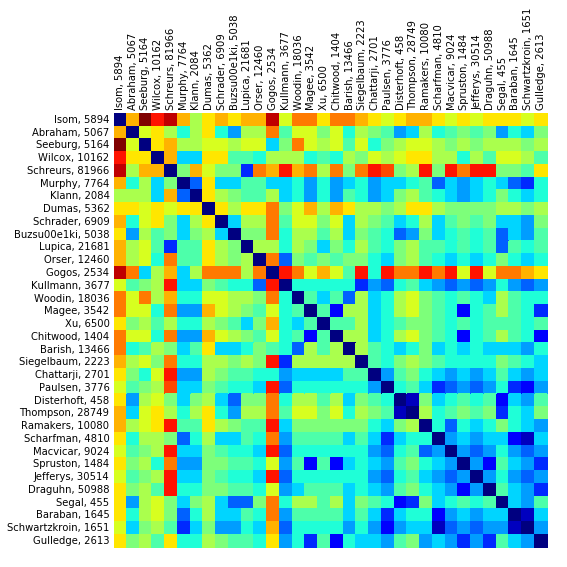

In [18]:
# plot the pairwise matrix of neurotree minimum path lengths

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
heatmap = ax.pcolor(min_df)

fig = plt.gcf()
fig.set_size_inches(8, 8)

# turn off the frame
ax.set_frame_on(False)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(min_df.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(min_df.shape[1]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

labels = names

ax.set_xticklabels(labels, minor=False)
ax.set_yticklabels(labels, minor=False)
plt.xticks(rotation=90)
ax.grid(False)

# Turn off all the ticks
ax = plt.gca()

for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False

In [19]:
# now getting back to the analysis of the neuroelectro data
# define a matrix composed of CA1 publication metadata values
# uses ca1_df defined above, a subset of the neuroelectro data import

from sklearn.preprocessing import Imputer, StandardScaler
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
imputer = Imputer(strategy='median',axis=0)
biscaler = BiScaler(center_rows = False, scale_rows = False)
standardscaler = StandardScaler()

x_features = ['Species','Strain','ElectrodeType',
            'PrepType','JxnPotential','JxnOffset','RecTemp','AnimalAge','AnimalWeight',
            #'PubYear', 
            'external_0_Mg','external_0_Ca','external_0_Na','external_0_Cl','external_0_K',
            'external_0_pH','internal_0_Mg',
            'internal_0_Ca','internal_0_Na','internal_0_Cl','internal_0_K','internal_0_pH']

x_df = ca1_df[x_features]
x_df.loc[:,'AnimalAge'] = np.log10(x_df[['AnimalAge']])
x_df.loc[:,'JxnOffset'] = np.abs(x_df[['JxnOffset']])

# Replace columns of the feature matrix that contain labels (i.e. words) with columns
# of indicator variables.  Also re-encode NaNs.  
X_clean = None
new_features = []
for f in x_features:
    mlb = None
    col = x_df[f].as_matrix().copy()
    try:
        new_cols = col.astype('float').reshape(-1,1)
    except ValueError:
        options = []
        for i in range(len(col)):
            if type(col[i]) is float:
                col[i] = 'NaN'
            col[i] = col[i].split(', ')
            for option in col[i]:
                options.append(option)
        options = list(set(options))
        mlb = MultiLabelBinarizer()
        new_cols = mlb.fit_transform(col)
    if X_clean is not None:
        X_clean = np.hstack((X_clean,new_cols))
    else:
        X_clean = new_cols
    if mlb is None:
        new_features += [f]
    else:
        new_features += ['%s_%s' % (f,mlb.classes_[i]) for i in range(new_cols.shape[1])]
        
# center and scale columsn so they have unit variance
X_scaled = biscaler.fit_transform(X_clean)

X_imputed = KNN(k=3).complete(X_scaled)

# the final data frame for metadata
x_matrix_df = pd.DataFrame(X_imputed, index = ca1_df.index)

Using Theano backend.
[BiScaler] Initial log residual value = 13.859363
[BiScaler] Iter 1: log residual = -62.885378, log improvement ratio=76.744742
[BiScaler] Iter 2: log residual = -62.885378, log improvement ratio=0.000000
Computing pairwise distances between 120 samples
Computing distances for sample #1/120, elapsed time: 0.001
Computing distances for sample #101/120, elapsed time: 0.004
Imputing row 1/120 with 8 missing columns, elapsed time: 0.005
Imputing row 101/120 with 5 missing columns, elapsed time: 0.010


In [20]:
# define a matrix composed of CA1 publication ephys values

y_var_names = ['rin','rmp','apthr','apamp','aphw','tau','ahpamp'] 
ndf = ca1_df[y_var_names]
has_non_na_y_vals = ndf[y_var_names].isnull().all(axis=1)
ndf.loc[has_non_na_y_vals,'rin'] = 100

#print has_non_na_y_vals
print(ndf.loc[has_non_na_y_vals]['rin'])

y_matrix = ndf.as_matrix()
#imputer = Imputer(strategy='median',axis=0)
biscaler = BiScaler(center_rows = False, scale_rows = False)
standardscaler = StandardScaler()

# center and scale columsn so they have unit variance
Y_scaled = biscaler.fit_transform(y_matrix)

y_matrix_imputed = KNN(k=3).complete(Y_scaled)

#the final y matrix of ephys values
y_matrix_df = pd.DataFrame(y_matrix_imputed, index = ca1_df.index)

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1189    100
Name: rin, dtype: float64
[BiScaler] Initial log residual value = 10.128494
[BiScaler] Iter 1: log residual = -67.218923, log improvement ratio=77.347416
[BiScaler] Iter 2: log residual = -67.218923, log improvement ratio=0.000000
Computing pairwise distances between 120 samples
Computing distances for sample #1/120, elapsed time: 0.000
Computing distances for sample #101/120, elapsed time: 0.003
Imputing row 1/120 with 4 missing columns, elapsed time: 0.004
Imputing row 101/120 with 4 missing columns, elapsed time: 0.007
[KNN] Warning: 4/840 still missing after imputation, replacing with 0


In [21]:
# Predict ephys parameters using 

# Fit the model, using cross-validation with 100 train/test splits.  
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import mean_squared_error

rfc = RandomForestRegressor(n_estimators=100,random_state=0)

rfc.fit(X_imputed,y_matrix_imputed)
Y_predict = rfc.predict(X_imputed)

y_resid = Y_predict - y_matrix_imputed
y_resid_df = pd.DataFrame(y_resid, index = ca1_df.index)

In [22]:
# for each pair of rows in the neuroelectro ca1 data frame, get the pairwise:
# 1) metadata (euclidean) distances
# 2) ephys (euclidean) distances
# 3) neurotree path length between last authors
# if no path exists between author pair from neurotree, call the path difference NaN

from scipy.spatial import distance

xm = pd.DataFrame(index = ca1_df.index, columns = ca1_df.index).fillna(value = np.nan)
ym = pd.DataFrame(index = ca1_df.index, columns = ca1_df.index).fillna(value = np.nan)
yresidm = pd.DataFrame(index = ca1_df.index, columns = ca1_df.index).fillna(value = np.nan)
pm = pd.DataFrame(index = ca1_df.index, columns = ca1_df.index).fillna(value = np.nan)

for index1, row1 in ca1_df.iterrows():
    x_vec1 = x_matrix_df.loc[index1]
    y_vec1 = y_matrix_df.loc[index1]
    yresid_vec1 = y_resid_df.loc[index1]
    matching_df_inds = new_df['LastAuthor'].isin([row1['LastAuthor']])
    if not matching_df_inds.any():
        continue
    else:
        matching_df_inds = new_df[matching_df_inds]
        nt_id1 = matching_df_inds['NeuroTreeID'].values[0]
    for index2, row2 in ca1_df.iterrows():
        matching_df_inds2 = new_df['LastAuthor'].isin([row2['LastAuthor']])
        if not matching_df_inds2.any():
            continue
        else:
            matching_df_inds2 = new_df[matching_df_inds2]
            nt_id2 = matching_df_inds2['NeuroTreeID'].values[0]
            
            if nt_id1 in min_df.index.values and nt_id2 in min_df.index.values:
                pm.loc[index1,index2] = min_df.loc[nt_id1, nt_id2]
            else:
                continue
            
            x_vec2 = x_matrix_df.loc[index2]
            y_vec2 = y_matrix_df.loc[index2]
            yresid_vec2 = y_resid_df.loc[index2]
            #em.loc[index1,index2] = abs(m_val1 - m_val2)
            xm.loc[index1,index2] = distance.euclidean(x_vec1,x_vec2)
            ym.loc[index1,index2] = distance.euclidean(y_vec1,y_vec2)
            yresidm.loc[index1,index2] = distance.euclidean(yresid_vec1,yresid_vec2)
# define vectors composed of the pairwise differce matrices
inds = np.triu_indices(np.shape(pm)[0])
path_len_pairwise_vec = pm.values[inds]
methods_pairwise_vec = xm.values[inds]
ephys_pairwise_vec = ym.values[inds]
ephys_resid_pairwise_vec = yresidm.values[inds]

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/ipykernel/__main__.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [23]:
# calculate correlations between distance matrices

def correlations(min_thresh,max_thresh):
    use_inds = (min_thresh <= path_len_pairwise_vec) & (path_len_pairwise_vec < max_thresh) 
    masked_path = np.ma.masked_invalid(path_len_pairwise_vec[use_inds])
    masked_methods = np.ma.masked_invalid(methods_pairwise_vec[use_inds])
    masked_ephys = np.ma.masked_invalid(ephys_pairwise_vec[use_inds])

    print('Correlations, for neurotree path lengths of %.1f <= l <=%.1f' % (min_thresh,max_thresh))
    print('neurotree : metadata corr %.2f' % np.ma.corrcoef(masked_path, masked_methods)[0,1])
    print('neurotree : ephys corr %.2f' % np.ma.corrcoef(masked_path, masked_ephys)[0,1])
    print('metadata : ephys corr %.2f' % np.ma.corrcoef(masked_methods, masked_ephys)[0,1])

correlations(0,20.5)
correlations(0,10.5)
correlations(0,4.5)
correlations(0.5,20.5)

Correlations, for neurotree path lengths of 0.0 <= l <=20.5
neurotree : metadata corr 0.36
neurotree : ephys corr 0.33
metadata : ephys corr 0.36
Correlations, for neurotree path lengths of 0.0 <= l <=10.5
neurotree : metadata corr 0.41
neurotree : ephys corr 0.40
metadata : ephys corr 0.37
Correlations, for neurotree path lengths of 0.0 <= l <=4.5
neurotree : metadata corr 0.68
neurotree : ephys corr 0.64
metadata : ephys corr 0.63
Correlations, for neurotree path lengths of 0.5 <= l <=20.5
neurotree : metadata corr 0.14
neurotree : ephys corr 0.13
metadata : ephys corr 0.18


In [24]:
pairwise_df = pd.DataFrame({'path': path_len_pairwise_vec, 'meth': methods_pairwise_vec, 
                            'ephys': ephys_pairwise_vec, 'ephys_resid': ephys_resid_pairwise_vec})

use_inds = (path_len_pairwise_vec < 5.5) & (path_len_pairwise_vec > .5)
pairwise_df = pairwise_df[use_inds]

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/ggplot/stats/stat_smooth.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(['x'])


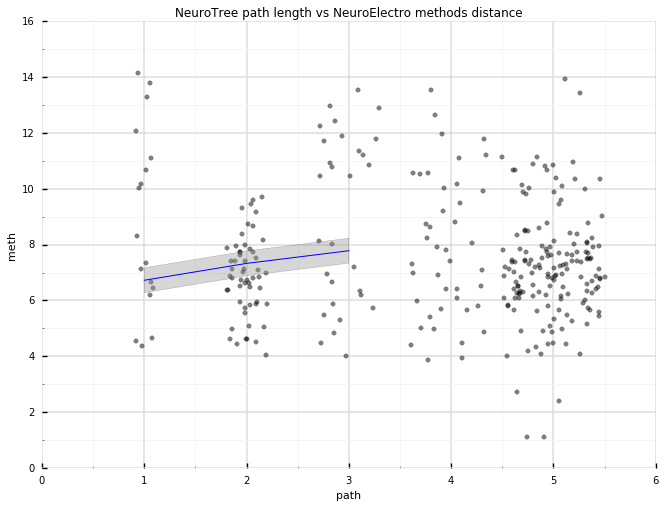

<ggplot: (290217669)>

In [25]:
from ggplot import *

# plot path len vs methods
ggplot(aes(x='path', y='meth'), data=pairwise_df) +\
    geom_point(position = 'jitter', alpha = .5) +\
    stat_smooth(colour="blue", se=True) +\
    theme_seaborn() +\
    ggtitle("NeuroTree path length vs NeuroElectro methods distance")

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


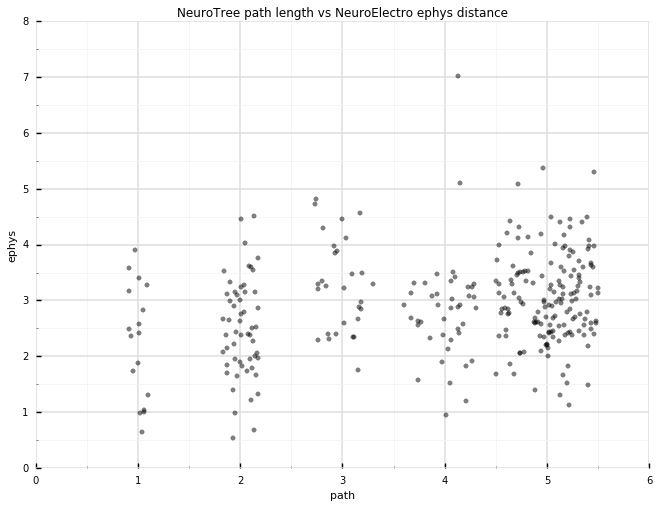

<ggplot: (287026980)>

In [26]:
# plot path len vs ephys diffs

ggplot(aes(x='path', y='ephys'), data=pairwise_df) +\
    geom_point(position = 'jitter', alpha = .5) +\
    stat_smooth(colour="blue", se=True) +\
    theme_seaborn() +\
    ggtitle("NeuroTree path length vs NeuroElectro ephys distance") 

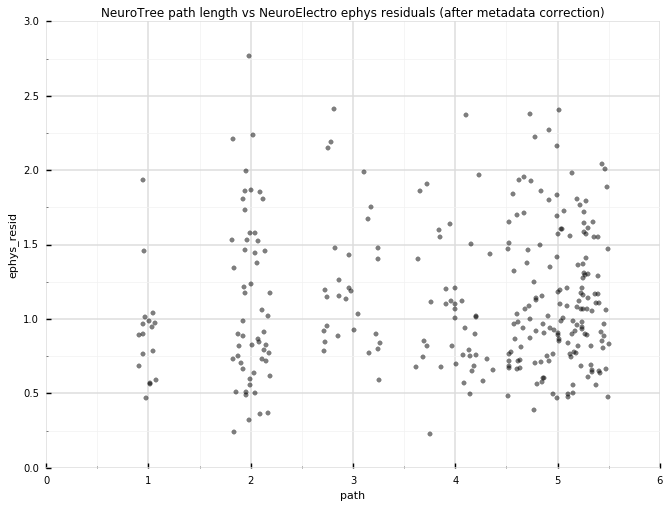

<ggplot: (-9223372036566701831)>

In [27]:
# plot path len vs ephys resid diffs (after accounting for known metadata - ephys corrs)

ggplot(aes(x='path', y='ephys_resid'), data=pairwise_df) +\
    geom_point(position = 'jitter', alpha = .5) +\
    stat_smooth(colour="blue", se=True) +\
    theme_seaborn() +\
    ggtitle("NeuroTree path length vs NeuroElectro ephys residuals (after metadata correction)") 

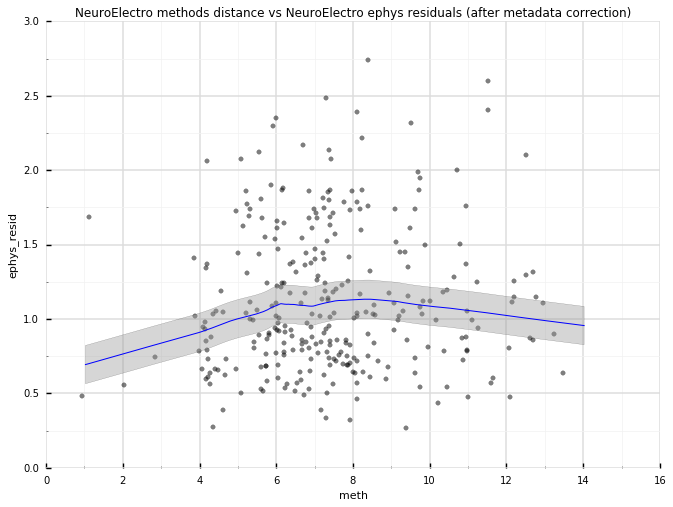

<ggplot: (-9223372036566309330)>

In [28]:
# plot path len vs ephys resid diffs (after accounting for known metadata - ephys corrs)

ggplot(aes(x='meth', y='ephys_resid'), data=pairwise_df) +\
    geom_point(position = 'jitter', alpha = .5) +\
    stat_smooth(colour="blue", se=True) +\
    theme_seaborn() +\
    ggtitle("NeuroElectro methods distance vs NeuroElectro ephys residuals (after metadata correction)") 

In [29]:
# fit a linear model predicting ephys pairwise differences using methods differences and 
# path len difference matrices as input

import statsmodels.api as sm
import matplotlib.pyplot as plt

# set the maximum path length to use for regression
MAX_PATH_LEN = 5.5
pairwise_df = pd.DataFrame({'path': path_len_pairwise_vec, 'meth': methods_pairwise_vec, 'ephys': ephys_pairwise_vec})
use_inds = path_len_pairwise_vec < MAX_PATH_LEN
pairwise_df = pairwise_df[use_inds]

X = pairwise_df[['meth']]
X = sm.add_constant(X)
y = pairwise_df[['ephys']].as_matrix()

model = sm.OLS(y, X, missing = 'drop')
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     215.4
Date:                Mon, 22 Feb 2016   Prob (F-statistic):           3.37e-39
Time:                        21:59:49   Log-Likelihood:                -575.24
No. Observations:                 395   AIC:                             1154.
Df Residuals:                     393   BIC:                             1162.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.0951      0.103     10.661      0.0